# Classifying Recorded Language

### MSIN0097: Predictive Analytics Indivivdual Assignment

# Table of Contents

* [1. Business Understanding](#1.-Business-Understanding)
* [2. Data Collection Proccess](#2.-Data-Collection-Process)
* [3. Data Description](#3.-Data-Description)
* [4. Data Exploration](#4.-Data-Exploration)
    * [4.1 Data Cleaning](#4.1-Data-Cleaning)
    * [4.2 Data Visualisation](#4.2-Data-Visualisation)
* [5. Modelling Preparation](#5.-Modelling-Preparation)
    * [5.1 Train-Test Split](#5.1-Train-Test-Split)
    * [5.2 Synthetic Data and Scaling](#5.2-Synthetic-Data-and-Scaling)
    * [5.3 Principal Component Analysis](#5.3-Principal-Component-Analysis)
* [6. Models](#6.-Models)   
    * [6.1 Support Vector Machine](#6.1-Support-Vector-Machine)
    * [6.2 Random Forest](#6.2-Random-Forest)
    * [6.3 XGBoost Forest](#6.3-XGBoost-Forest)
    * [6.4 Voting Classifier](#6.4-Final-Model)
    
* [7. Conclusion ](#7.-Conclusion)

# 1. Business Understanding

Throughout this report, we will attempt to create a model which can predict the language being that is currently being spoken. There is a plethora of use cases for such a model. For example, a navigation system could recognise the voice that is being spoken in a car to then respond in the corresponsing language. Or a translator could recognise the language being spoken in order to directly translate the voice into another language.


The model's performance will be based on how often the model is correct when it labels a voice as a certain language (precision) and how often each language was correctly identified in total (recall).





# 2. Data Collection Process

The data was collected as part of the "Production and Perception of Linguistic Voice Quality" project at UCLA. In order to collect the data, a software called VoiceSauce was used.

The recordings for each language were collected independently and subsequently aggregated by UCLA. Therefore, the words and phrases recorded in each language, as well as the number of individuals recorded, varies. 

The recorded languages are English, Bo (Chinese lanuguage), Miao (Chinese language),Yi (Chinese langauge), Hmong (Chinese language), Luchun (Chinese language), Zapotec (indigenous Columbian language), Mazatec (indigenous Mexican language), Gujarati (Indo-Aryan language) and Manadarin.



#### Limitations to data collection:

The fact that the a limited number of people were recorded hinders the usability of our model. For example, often only certain words were spoken instead of sentences which could harm the model accuracy in deployment. Furthermore the data does not capture enough accents and dialects to predict each language in the real world use. However, the data is sufficient to create a rudimentary language prediction model for the 9 langauges.


In [29]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
!pip install -U imbalanced-learn
!pip install imbalanced-learn
%matplotlib inline

# Display full output rather than just the last line of output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

     |████████████████████████████████| 206 kB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 24.9 MB 57.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1

         .:

In [2]:
#load data from website

url = 'http://www.phonetics.ucla.edu/voiceproject/Spreadsheet/Voice_Master.xlsx'

#Read file into a DataFrame

df = pd.read_excel(url, sep=';', encoding = 'utf-8')

In [3]:
#see head and shape of the data

voice_data = pd.DataFrame(df)
voice_data.head()
voice_shape = voice_data.shape
print("The dataset has {} rows and {} columns ".format(voice_shape[0], voice_shape[1]))

,Filename,0=do not use,Label,Language,Dialect/Village,Sex,Speaker #,Speaker,Lang_Spk,Phonation,...,sB4_mean,sB4_means001,sB4_means002,sB4_means003,sB4_means004,sB4_means005,sB4_means006,sB4_means007,sB4_means008,sB4_means009
0,F19May20_sure_normal.mat,0 end,r,English,NaN,F,19,F19,English_F19,M,...,263.529,217.219,272.275,230.260,215.393,178.683,158.294,209.815,348.863,542.583
1,F19May20_sure_normal.mat,0 end,r,English,NaN,F,19,F19,English_F19,M,...,375.086,354.539,448.949,254.102,159.089,220.819,198.345,227.356,592.842,908.053
2,F19May20_sure_normal.mat,0,r,English,NaN,F,19,F19,English_F19,M,...,295.344,407.098,357.500,242.458,224.664,200.499,192.645,229.259,363.865,434.302
3,F1July22_sure_normal.mat,0 end,r,English,NaN,F,1,F1,English_F1,M,...,277.880,131.692,410.788,366.203,183.711,213.710,246.977,328.101,265.039,357.186
4,F1July22_sure_normal.mat,0 end,r,English,NaN,F,1,F1,English_F1,M,...,335.320,209.534,376.419,357.762,191.279,250.888,322.978,439.648,573.923,291.340


The dataset has 16833 rows and 474 columns 


# 3. Data Description


As seen above, the data collates 474 variables which are used to capture characteristics of voices.

In general, there are three groups of measurements:

- F0/CPP/E/HNR- variables that measure the pitch and energy of the recording in Herz
- Formants - the variables such as F2,F3 etc. These are concentrations of energy around certain frequencies which are hit when speaking
- Hx-Ax - these variables contain the harmonic frequencies relative to their amplitude


F0, known as the fundamental frequency, is the main voice measure. The fundamental frequency is the lowest frequency in each respective sound wave.

VoiceSauce collects data on the fundamental frequency using four different algorithms which are captured as separate variables.

- shrF0 - Subharmonic-to-Harmonic Ratio method

- strF0 - Straight method (Kawahara et al. 1998)

- sF0 - Snack Sound Toolkit method (Sjölander 2004)

- pF0 - using Praat (a phonetics software)

The variables H1,H2,H4 capture harmonics of the respective fundamental frequency. A harmonic refers to the **frequency** one multiple higher than the fundamental frequency. For example, if a fundamental frequency was 100Hz, the first harmonic would be 200Hz.

Variables A1,A2,A3 refer to the **amplitude** of the harmonics. In acoustics, frequency refers to the speed of the vibration and amplitude to the size of the vibration.

Variables sF1-4 and pF1-4 refer to the formants based on the fundamental frequencies gained from the Snack sound toolkit and Praat systems.

The HNR or Harmonic to Noise Ratio variables capture how much additive noise, or jitter, is in a voice signal at different frequencies.

Energy variable refers to the root mean squared energy captured in the recording.

The variable CCP refers to the cepstral peak prominence. This measures the breathiness of the voice recorded.

The variables sB1-4 capture the bandwidth of the formant frequencies. Bandwidth refers to the difference in the upper and lower bound of the formant frequency.

Each variable output is the result of nine measurements which each have their own column. For example, the variable sB4_mean is the mean results of sB4_means001,sB4_means002... Therefore, we can delete the individual measurements and keep the mean.

Furthermore, there are multiple variables which are in the dataset in  both corrected and uncorrected format. These are labled by either having a 'u' or a 'c' nect to them. Only the corrected variables will be used in this analysis.

Finally there are some columns which are not interesting for our analysis. These columns mostly summarise the information about the speaker or the words recorded which are not part of the scope of this project.

# 4. Data Exploration

## 4.1 Data Cleaning

In [4]:
#Only interested in the mean columns, delete columns that aren't mean

voice_data.drop(voice_data.filter(regex='means').columns, axis=1, inplace=True)

#delete uncorrected variables

voice_data.drop(voice_data.filter(regex='u_').columns, axis=1, inplace=True)

#drop unneeded columns
columns = [0,1,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

voice_data.drop(voice_data.columns[columns], axis =1, inplace = True)

#delete _mean from column names for cleaner variable names

voice_data.columns = voice_data.columns.str.replace("_mean", "")


In [5]:
#see the ditribution of languages in %

round(voice_data["Language"].value_counts(normalize = True),3)*100


Luchun      22.0
Gujarati    19.7
Bo          14.5
Yi          13.4
Hmong       11.9
Miao         9.9
Mandarin     3.0
Mazatec      3.0
Zapotec      2.0
English      0.4
Name: Language, dtype: float64

We can see that the classes of our distribution are not very evenly distributed. The majority class, Luchun, has 22% of the data.

The minority class, English, only has 0.4% of the data. Even though there are methods to rectify imbalanced data, the percentage of instances is too low, so we will delete the class.


In [6]:
#delete english language 

voice_data.drop(voice_data.index[voice_data['Language'] == 'English'], inplace = True)

The next step is to see whether there are any duplicated rows.

In [7]:
#check if there are any duplicated instances

duplicates = voice_data.duplicated().sum()

if duplicates == 0:
    print("There are no duplicated rows")
else:
    print("There are {} duplicated rows".format(duplicates))
    

There are no duplicated rows


Next, we will look for null values.

In [8]:
#display columns with null values and how many instances with null values they have

def null_columns():
    columns = voice_data.isna().sum()
    for col, null_values in columns.items():
        if null_values > 0:
            print(col, null_values)
            
null_columns()

SHR 57
shrF0 1560
pF0 57
pF1 57
pF2 57
pF3 57
pF4 57


ShrF0 is one of the four fundamental frequencies VoiceSauce measures. No other harmonics, formants or bandwidths are measured against the shrF0 value. The information lost by dropping this variable will most likely be minimal, therefore this is the preferred choice of action.


In [9]:
#drop shrF0 column

voice_data.drop("shrF0", axis =1, inplace = True)

In [10]:
#find what language the rest of the missing values are attributed to

miss =voice_data[voice_data.isnull().any(axis=1)]
miss["Language"].value_counts()

Gujarati    57
Name: Language, dtype: int64

Now there are 57 rows left with missing data left in them. We can see that there was an issue with recording the fundamental frequency using the Praat and Straight methods. Following, the formants, which are based on the fundamental frequency could not be measured.

We will fill these values with their median value to not lose any data.

In [11]:
#fill in missing values with median

voice_data = voice_data.fillna(voice_data.median())


In [12]:
#check data types of the variables

voice_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16766 entries, 67 to 16832
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Language   16766 non-null  object 
 1   Phonation  16766 non-null  object 
 2   H1c        16766 non-null  float64
 3   H2c        16766 non-null  float64
 4   H4c        16766 non-null  float64
 5   A1c        16766 non-null  float64
 6   A2c        16766 non-null  float64
 7   A3c        16766 non-null  float64
 8   H1H2c      16766 non-null  float64
 9   H2H4c      16766 non-null  float64
 10  H1A1c      16766 non-null  float64
 11  H1A2c      16766 non-null  float64
 12  H1A3c      16766 non-null  float64
 13  CPP        16766 non-null  float64
 14  Energy     16766 non-null  float64
 15  HNR05      16766 non-null  float64
 16  HNR15      16766 non-null  float64
 17  HNR25      16766 non-null  float64
 18  HNR35      16766 non-null  float64
 19  SHR        16766 non-null  float64
 20  strF0

Checking the object type, we see that all variables are in the correct format.

## 4.2 Data Visualisation

As the phonation could be useful for our model, we will create dummy variables that can be read by our models. The phonation types are categorised as the following:

M = Modal (regular)

C = Creaky (lower airflow)

B = Breathy (less contact of vocal cords)

L = Lax (looser vibrations)

T = Tense (stiffer vibrations)

In [13]:
#create dummy variables for the five phonation types

voice_data = pd.concat([voice_data, pd.get_dummies(voice_data["Phonation"], prefix = "Phonation")],axis = 1)

In order to see which variables are the most correlated with each language, we will create dummy variables for each language.

In [14]:
#create dummy variables for the nine languages

voice_data = pd.concat([voice_data, pd.get_dummies(voice_data["Language"], prefix = "Lang")],axis = 1)

In [15]:
# get the correlations of the individual variables

corr = round(voice_data.corr().abs().unstack().drop_duplicates().sort_values(ascending = False),2)

#print DataFrame of highly correlated variables (over 0.75)

high_corr = pd.DataFrame(corr[(corr > 0.75)& (corr < 1) ], columns = ["Correlations"])
print(high_corr)



                 Correlations
HNR25 HNR35              0.98
HNR15 HNR25              0.96
pF3   Lang_Miao          0.94
HNR15 HNR35              0.92
pF2   pF3                0.88
H1c   H2c                0.88
H4c   A1c                0.88
H2c   H4c                0.82
HNR05 HNR15              0.81
pF2   Lang_Miao          0.80
pF4   Lang_Miao          0.79
H4c   A2c                0.78
A1c   A2c                0.77
H1c   H4c                0.76
HNR05 HNR25              0.76


The table above shows how the language Miao is highly correlated with one of the formant measurements. It also highlights that some variables such as the HNR metrics, are highly correlated. Let's plot the correlations.

In [16]:
#create target set (language) and feature variable sets

voice_target = voice_data["Language"]
voice_features = voice_data.iloc[:, 2:]

<Figure size 864x720 with 0 Axes>

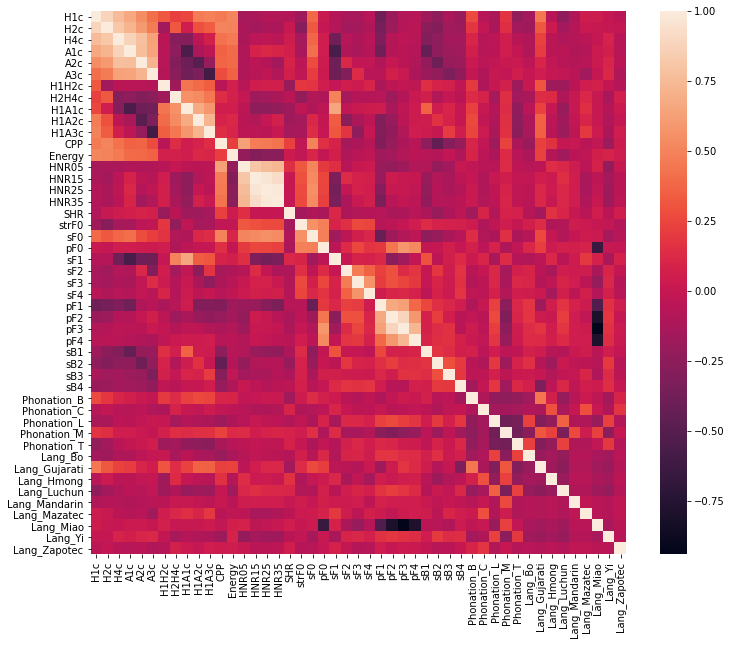

In [17]:
#plot the correlations in a heatmap

import matplotlib.pyplot as plt
import seaborn as sns 


plt.figure(figsize=(12,10))
heatmap = sns.heatmap(voice_features.corr())


We can see some very highly correlated variables. For example, the Miao language seems to be highly correlated with the fundamental frequency measured through Praat. Subsequently, the harmonics pF1-4 are also highly correlated with the language. 

Furthermore, we can see that the four Harmony to Noise ratios are highly correlated. This begs the question of whether we need all of them in our analysis. However, we can assume that our principal component analysis later will sort this out.

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Miao Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Mandarin Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Yi Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Gujarati Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Bo Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Mazatec Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Zapotec Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Hmong Phonation')

(0.0, 1.0)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Luchun Phonation')

(0.0, 1.0)

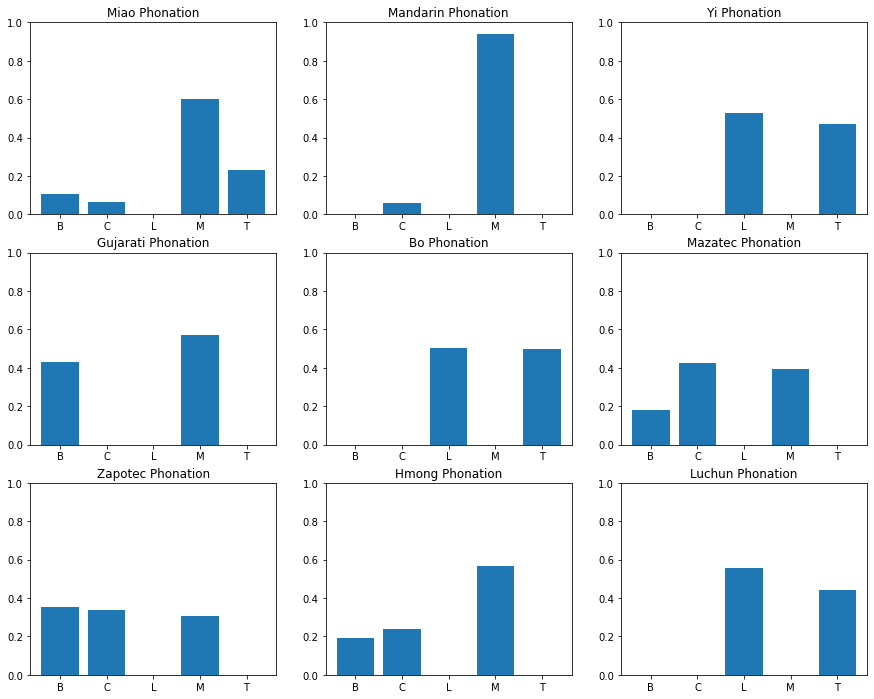

In [18]:
#For each Language create a df with their respective phonation distribution as a percentage

miao = voice_data[voice_data["Language"] == "Miao"]["Phonation"].value_counts(normalize=True)
mand = voice_data[voice_data["Language"] == "Mandarin"]["Phonation"].value_counts(normalize=True)
yi = voice_data[voice_data["Language"] == "Yi"]["Phonation"].value_counts(normalize=True)
guj = voice_data[voice_data["Language"] == "Gujarati"]["Phonation"].value_counts(normalize=True)
bo = voice_data[voice_data["Language"] == "Bo"]["Phonation"].value_counts(normalize=True)
maz = voice_data[voice_data["Language"] == "Mazatec"]["Phonation"].value_counts(normalize=True)
zap = voice_data[voice_data["Language"] == "Zapotec"]["Phonation"].value_counts(normalize=True)
hmong = voice_data[voice_data["Language"] == "Hmong"]["Phonation"].value_counts(normalize=True)
luch = voice_data[voice_data["Language"] == "Luchun"]["Phonation"].value_counts(normalize=True)


#reindex each language and fill the missing values with 0 for better side-to-side comparison

miao = miao.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
mand = mand.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
yi = yi.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
guj = guj.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
bo = bo.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
maz = maz.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
zap = zap.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
hmong = hmong.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)
luch = luch.reindex(['B', 'C', 'L', 'M', 'T'], fill_value = 0)


# set up subplots 

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize=(15,12))

# define height of bar graphs
x = ["B", "C", "L", "M", "T"]

#set axis of bar graphs

ax1.bar(x, miao)
ax1.grid(False)
ax1.set_title("Miao Phonation")
ax1.set_ylim([0, 1])
ax2.bar(x, mand)
ax2.grid(False)
ax2.set_title("Mandarin Phonation")
ax2.set_ylim([0, 1])
ax3.bar(x, yi)
ax3.grid(False)
ax3.set_title("Yi Phonation")
ax3.set_ylim([0, 1])
ax4.bar(x, guj)
ax4.grid(False)
ax4.set_title("Gujarati Phonation")
ax4.set_ylim([0, 1])
ax5.bar(x, bo)
ax5.grid(False)
ax5.set_title("Bo Phonation")
ax5.set_ylim([0, 1])
ax6.bar(x, maz)
ax6.grid(False)
ax6.set_title("Mazatec Phonation")
ax6.set_ylim([0, 1])
ax7.bar(x, zap)
ax7.grid(False)
ax7.set_title("Zapotec Phonation")
ax7.set_ylim([0, 1])
ax8.bar(x, hmong)
ax8.grid(False)
ax8.set_title("Hmong Phonation")
ax8.set_ylim([0, 1])
ax9.bar(x, luch)
ax9.grid(False)
ax9.set_title("Luchun Phonation")
ax9.set_ylim([0, 1])


Looking at the distribution of the phonation between the languages we can see some important differences. Notbaly that the Miao, Mandarin and Hmong have modal phonation when they speak. Especially for Mandarin, the modal phonation seems to be a defining feature of the language. The Yi, Bo and Luchun have either a lax or tense vibration but not modal.

The Zapotec and Mazatec have similar phonation, with voices categorised as modal, breathy and creaky. The differences in distribution of the phonation between the language is an indicator that this variable may be a strong factor in classifying the spoken language.

Next, we will visualise the fundamental requency of each language.


Text(0.5, 1.0, 'Miao Fundamental Frequency')

Text(0.5, 1.0, 'Mandarin Fundamental Frequency')

Text(0.5, 1.0, 'Yi Fundamental Frequency')

Text(0.5, 1.0, 'Gujarati Fundamental Frequency')

Text(0.5, 1.0, 'Bo Fundamental Frequency')

Text(0.5, 1.0, 'Mazatec Fundamental Frequency')

Text(0.5, 1.0, 'Zapotec Fundamental Frequency')

Text(0.5, 1.0, 'Hmong Fundamental Frequency')

Text(0.5, 1.0, 'Luchun Fundamental Frequency')

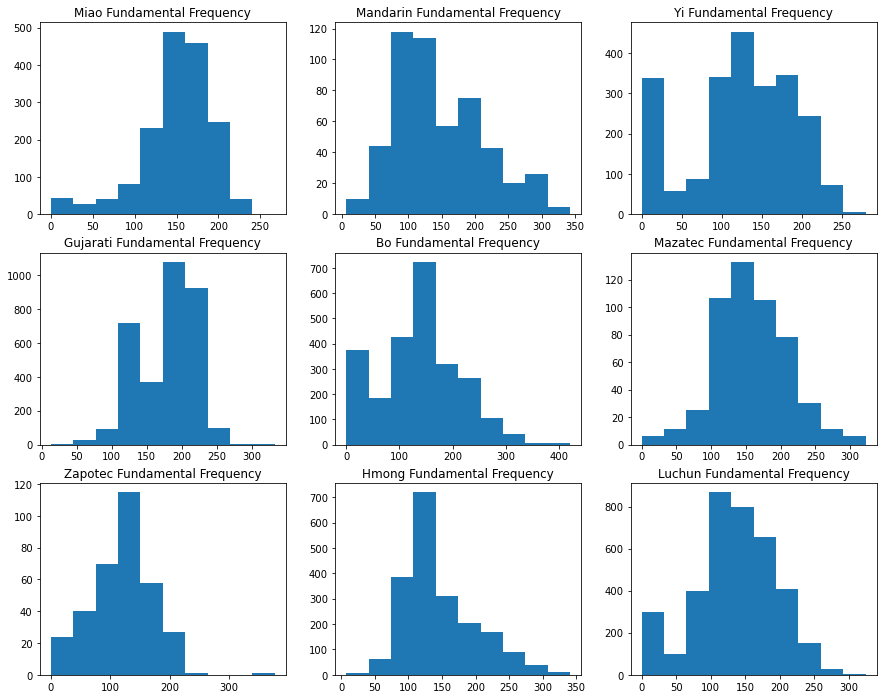

In [19]:
# get the fundamental freqeuncy for each language. 

miao1 = voice_data[voice_data["Language"] == "Miao"]["sF0"]
mand1 = voice_data[voice_data["Language"] == "Mandarin"]["sF0"]
yi1 = voice_data[voice_data["Language"] == "Yi"]["sF0"]
guj1 = voice_data[voice_data["Language"] == "Gujarati"]["sF0"]
bo1 = voice_data[voice_data["Language"] == "Bo"]["sF0"]
maz1 = voice_data[voice_data["Language"] == "Mazatec"]["sF0"]
zap1 = voice_data[voice_data["Language"] == "Zapotec"]["sF0"]
hmong1 = voice_data[voice_data["Language"] == "Hmong"]["sF0"]
luch1 = voice_data[voice_data["Language"] == "Luchun"]["sF0"]

# set up subplots 


fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize=(15,12))

#set axis of bar graphs

miao1.hist(ax = ax1)
ax1.grid(False)
ax1.set_title("Miao Fundamental Frequency")
mand1.hist(ax =ax2)
ax2.grid(False)
ax2.set_title("Mandarin Fundamental Frequency")
yi1.hist(ax =ax3)
ax3.grid(False)
ax3.set_title("Yi Fundamental Frequency")
guj1.hist(ax =ax4)
ax4.grid(False)
ax4.set_title("Gujarati Fundamental Frequency")
bo1.hist(ax =ax5)
ax5.grid(False)
ax5.set_title("Bo Fundamental Frequency")
maz1.hist(ax =ax6)
ax6.grid(False)
ax6.set_title("Mazatec Fundamental Frequency")
zap1.hist(ax =ax7)
ax7.grid(False)
ax7.set_title("Zapotec Fundamental Frequency")
hmong1.hist(ax =ax8)
ax8.grid(False)
ax8.set_title("Hmong Fundamental Frequency")
luch1.hist(ax=ax9)
ax9.grid(False)
ax9.set_title("Luchun Fundamental Frequency")



We can see that some languages, such as Hmong, Luchun, Zapotec and Mandarin have a slightly lower median fundamental frequency around 125Hz. Miao, Mazatec, Gujarati and Bo seem to have a slightly higher distribution with a median aroun 150Hz. 

Next, we will run feature importance using a random forest model to find out which variables are the most important in determining a language.

In [20]:
#create voice f set which drops the language dummmy columns from voice_features

voice_f = voice_features.drop(["Lang_Yi", "Lang_Bo", "Lang_Gujarati", "Lang_Luchun", "Lang_Miao", "Lang_Mandarin", "Lang_Zapotec", "Lang_Mazatec", "Lang_Hmong"],1)

RandomForestClassifier(random_state=42)

<Figure size 648x504 with 0 Axes>

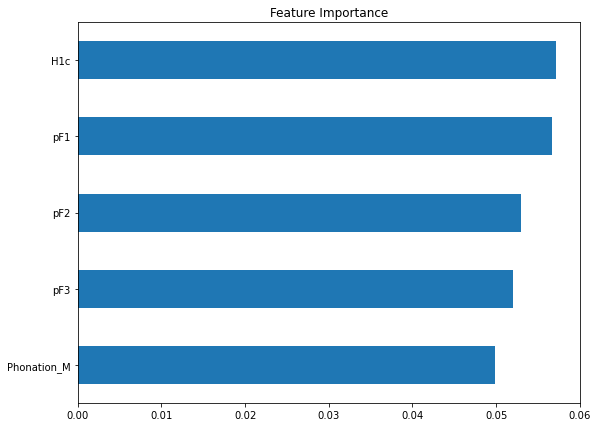

In [21]:
from sklearn.ensemble import RandomForestClassifier

#train random forest

randf = RandomForestClassifier(random_state=42)
randf.fit(voice_f, voice_target)

#rank the most important features

feat_importances = pd.Series(randf.feature_importances_, index=voice_f.columns)

#plot the 5 most important features 

plt.figure(figsize=(9,7))

feat_importances.nlargest(5).sort_values(ascending= True).plot(kind='barh', title = "Feature Importance")


We see that the first harmonic and three formants are the most important features. However, as seen earlier, this may be due to the high correlation with the Miao language. We will train the random forest again without the Miao language and see whether we get the same results.

In [22]:
# create new dataset without Miao language
voice_data_noMiao = voice_data.loc[voice_data["Language"].isin(["Mandarin", "Yi", "Zapotec", "Gujarati", "Luchun", "Hmong", "Mazatec", "Bo"])]

#drop Miao dummy variable
voice_data_noMiao = voice_data_noMiao.drop(["Lang_Yi", "Lang_Bo", "Lang_Gujarati", "Lang_Luchun", "Lang_Miao", "Lang_Mandarin", "Lang_Zapotec", "Lang_Mazatec", "Lang_Hmong"],1)

#create new features and target variable
voice_target_noMiao = voice_data_noMiao["Language"]
voice_features_noMiao = voice_data_noMiao.iloc[:, 2:]

RandomForestClassifier(random_state=42)

<Figure size 648x504 with 0 Axes>

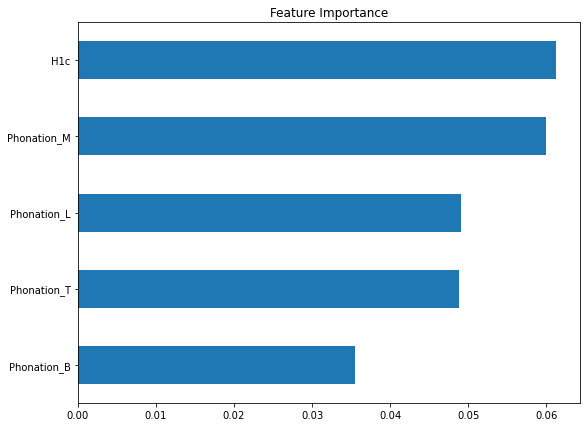

In [23]:
# rerun random forest using new features data

randf1 = RandomForestClassifier(random_state=42)
randf1.fit(voice_features_noMiao, voice_target_noMiao)

# rerun to find the most important features without Miao

feat_importances1 = pd.Series(randf1.feature_importances_, index=voice_f.columns)

#plot the 5 most important features 

plt.figure(figsize=(9,7))

feat_importances1.nlargest(5).sort_values(ascending= True).plot(kind='barh', title = "Feature Importance")

Indeed, without Miao, the feature importance changes to almost exclusively the phonation. However, interestingly the first harmonic remains the most important feature. Let's plot the variable to see the difference in languages.

<Figure size 1008x792 with 0 Axes>

Text(0.5, 1.0, 'First Harmonic in Hz per Language')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 10 Text major ticklabel objects>)

Text(0.5, 0, 'Language')

Text(0, 0.5, 'Hz')

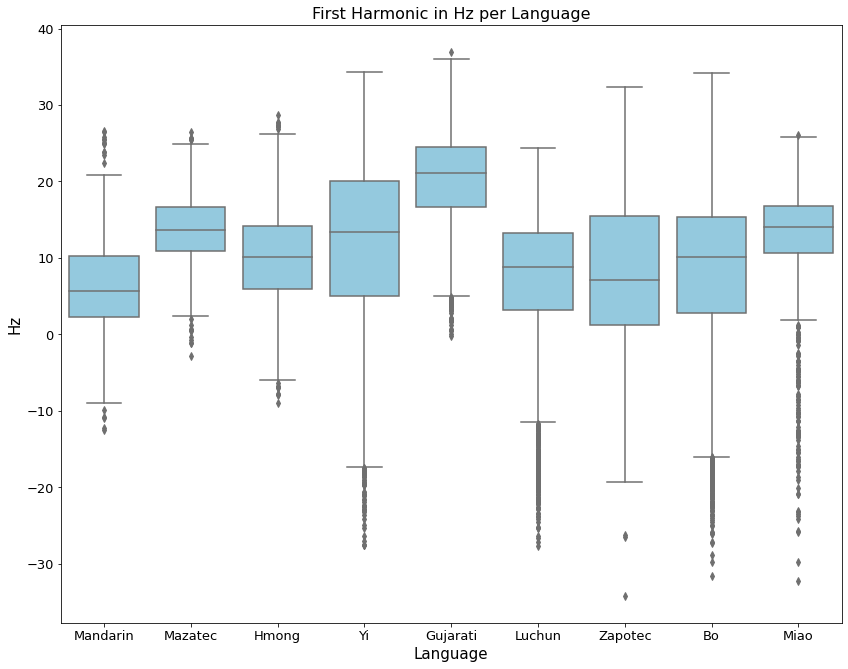

In [24]:
#set plotsize

plt.figure(figsize=(14,11))

#draw boxplot

sns.boxplot(x="Language", y="H1c", data= voice_data, color = 'skyblue')
plt.title("First Harmonic in Hz per Language", fontsize= 16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Language',fontsize=15)
plt.ylabel("Hz" ,fontsize=15)

Th boxplot above highlights how the first harmonic in Gujarati is substantially higher than those of the other languages. Moreover, the distribution is quite dense, with the majority of the data ranging from 5 to 35Hz. Similary, Mazatec, Mandarin and Hmong have a relatively small first harmonic range.

Yi, Luchun, Zaptec and Bo, in contrast, have a large range meaning the range of their voices when speaking is higher than that of the other languages. The frequency range of a spoken language is interesting because it is quite a defining characteristic in the way we perceive languages.

# 5. Modelling Preparation

## 5.1 Train-Test Split

We will stratify our data based on language to ensure the training and test set have the same proportion of languages.

In [25]:
#split data in training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(voice_f, voice_target, test_size = 0.3, random_state = 42, stratify = voice_target)

In [26]:
#Find how many counts per Language there are

y_train.value_counts()

Luchun      2594
Gujarati    2325
Bo          1714
Yi          1585
Hmong       1402
Miao        1164
Mazatec      359
Mandarin     358
Zapotec      235
Name: Language, dtype: int64

Zapotec, only has 235 which is less than 10% of the majority class. An issue with imbalanced data is that its skews the model's performance, often resulting in a high bias as more preictions will be classified to the majority class.

In order to counteract this imbalance, we will create synthetic data using with SMOTE technique which oversamples classes so that each has the same amount as the majority class.

## 5.2 Synthetic Data and Scaling

In [31]:
# create synthetic data using SMOTE for underrepresented classes

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

ImportError: cannot import name 'delayed' from 'sklearn.utils.fixes' (/opt/anaconda/envs/Python3/lib/python3.8/site-packages/sklearn/utils/fixes.py)

We can now consider scaling our features. This form of standardisation subtracts the mean value and divides by the standard deviation of the variable, thus creating a mean centering around 0 for each variable.

Standardisation improves the performance for certain models such as Support Vector Machines as the model will treat each scaled variable with the same weight.

In [ ]:
# scale data using StandardScaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 5.3 Principal Component Analysis

We still have 47 variables, some of which are very highly correlated (as seen in the correlation table above). Highly correlated independent variables can cause multicollinearity problems with certain models. To address this, we can perform principal component analysis.

First, we will reduce the number of components to 3 and visualise our data to get a better understanding of where our data lies.

In [ ]:
# compress data to three components using PCA

from sklearn.decomposition import PCA

pca = PCA(n_components= 3).fit(X_train)

#see how much variance each principal component explains

pca.explained_variance_ratio_

In [32]:
#Create dictionary to prepare for PCA visualisation

y = y_train.astype('category')
d = dict(enumerate(y.cat.categories))

#swap key and values and map to new variable so we have a legend on the PCA visualisation.
dic = {value:key for key, value in d.items()}
dic
y3d = y_train.map(dic)

{'Bo': 0,
 'Gujarati': 1,
 'Hmong': 2,
 'Luchun': 3,
 'Mandarin': 4,
 'Mazatec': 5,
 'Miao': 6,
 'Yi': 7,
 'Zapotec': 8}

In [33]:
y3d

15304    6
12955    0
3305     7
12277    8
13731    0
        ..
7645     7
6914     1
15920    6
16368    6
11829    3
Name: Language, Length: 11736, dtype: int64

In [34]:
# 3D visualise. Code structure from https://python-graph-gallery.com/372-3d-pca-result/

from mpl_toolkits.mplot3d import Axes3D


# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(X_train), columns=['PCA%i' % i for i in range(3)])
 
# Plot initialisation
fig = plt.figure(figsize=(22,15))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c = y3d ,cmap=plt.cm.get_cmap('nipy_spectral',9), alpha=0.5)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label and shape the axes
ax.set_xlabel("component 1", fontsize =14)
ax.set_xlim([-7.5, 6.5])
ax.set_ylabel("component 2", fontsize =14)
ax.set_ylim([-5,6])
ax.set_zlabel("component 3", fontsize =14)
ax.set_zlim([-7.5,6])
ax.set_title("Three-Dimensional PCA", fontsize =20)
fig.colorbar(p)
dic

NameError: name 'pca' is not defined

We can see some clusters in the visualisation above such as Miao (6) in the top of the graph and Gujarati (1) just below it.

Nevertheless for our modelling we need to retain more variation in the data. To find the optimal components we can draw the cumulative variance exaplained for each number of components.


Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Cumulative Variance Explained')

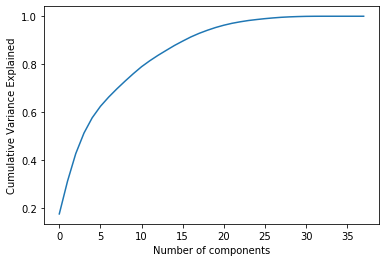

In [39]:
#data structure from https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

#fit pca to training data

pca = PCA().fit(X_train)

#plot the cumulative variance explained

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative Variance Explained')

Unfortunately, there is no clear 'elbow' in the graph to help us draw the line. Instead, we can choose the number of components based the amount of variance we wish to retain.

The PCA below compresses the number of variables down to 20 from 47 whilst retaining 95% of the variance. In addition to saving space, the PCA will also decrease the run-time of our models and help prevent overfitting.

In [40]:
#train pca to retain 95% of the variance

pca = PCA(n_components= 0.95)

# fit it to the training data and transform the test data
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#return how many components we are left with

pca.n_components_

20

# 6. Models

We can now start building our models.

## 6.1 Support Vector Machine

In [41]:
from sklearn.svm import SVC

#train and fit SVM on training data

poly_svc = SVC(random_state = 42)

poly_svc.fit(X_train, y_train)


SVC(random_state=42)

In [42]:
#see how the SVM performs on the training data

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


y_pred_svc = poly_svc.predict(X_train)


prec_score_svc = precision_score(y_train, y_pred_svc, average = 'macro')
print("%0.2f training precision score" % (prec_score_svc))

      
rec_score_svc = recall_score(y_train, y_pred_svc, average = 'macro')
print("%0.2f training recall score" % (rec_score_svc))

0.91 training precision score
0.91 training recall score


Let's see if we can improve the score using grid search to tune our hyperparameters.

In [ ]:
# run grid search to see whether we can increase its performance

param_grid = {
    'C':[0.5,1,3,5,8],'gamma':[0.5,1,3,5,8], 'kernel':['linear','rbf', 'poly']
}

grid_search = GridSearchCV(poly_svc, param_grid=param_grid, cv= 2, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_


In [44]:
#use fine tuned parameters to retrain the SVM

poly_svc_grid = SVC(kernel='poly', degree=3, C=1, gamma = 0.5, probability = True, random_state = 42)

poly_svc_grid.fit(X_train, y_train)



SVC(C=1, gamma=0.5, kernel='poly', probability=True, random_state=42)

In [45]:
#check performance on training data

y_pred_svc_grid = poly_svc_grid.predict(X_train)


prec_score_svc_grid = precision_score(y_train, y_pred_svc_grid, average = 'macro')
print("%0.2f training precision score" % (prec_score_svc_grid))

      
rec_score_svc_grid = recall_score(y_train, y_pred_svc_grid, average = 'macro')
print("%0.2f training recall score" % (rec_score_svc_grid))

1.00 training precision score
1.00 training recall score


## 6.2 Random Forest

In [46]:
#train random forest  

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [47]:
#check score against training data

y_pred_rf = rf.predict(X_train)

prec_score_rf = precision_score(y_train, y_pred_rf, average = 'macro')
print("%0.2f training precision score" % (prec_score_rf))
      
rec_score_rf = recall_score(y_train, y_pred_rf, average = 'macro')
print("%0.2f training recall score" % (rec_score_rf))

1.00 training precision score
1.00 training recall score


As we are dealing with a multiclassification problem, we will use the 'macro' way of calculating scores. Macro takes the scores of each class and produces the average.

We received 100% precision and recall on the training set with SVM and random forest. However, the models are likely overfit. We will therefore look at some further models before combining them in a voting classifier.


In [61]:
#do a grid search to improve random forest result
param_grid = {
    'bootstrap': [True],
    'criterion': ["gini", "entropy"],
    'max_depth': [20, 25, 30],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1 ,2, 3],
    'n_estimators': [200, 300, 400]
}

# grid_search = GridSearchCV(rf, param_grid=param_grid, cv= 2, verbose=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)
#grid_search.best_params_

In [48]:
#retrain model with fine tuned hyperparameters

rf2 = RandomForestClassifier(max_depth = 15, 
                             criterion = 'entropy', 
                             max_features = 2, 
                             min_samples_leaf = 1, 
                             min_samples_split = 2, 
                             n_estimators = 200, 
                             random_state = 42)
rf2.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=15, max_features=2,
                       n_estimators=200, random_state=42)

In [49]:
#check prediction against training data

y_pred_rf2 = rf2.predict(X_train)

prec_score_rf2 = precision_score(y_train, y_pred_rf2, average = 'macro')
print("%0.2f train precision score" % (prec_score_rf2))

      
rec_score_rf2 = recall_score(y_train, y_pred_rf2, average = 'macro')
print("%0.2f train recall score" % (rec_score_rf2))

1.00 train precision score
1.00 train recall score


## 6.3 XGBoost Forest

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

#train gradient boosted random forest model

gbc = GradientBoostingClassifier(n_estimators= 200, validation_fraction=0.2, n_iter_no_change=5, tol=0.01, random_state= 42)
gbc.fit(X_train, y_train)


GradientBoostingClassifier(n_estimators=200, n_iter_no_change=5,
                           random_state=42, tol=0.01, validation_fraction=0.2)

In order to prevent overfitting, we have implemented early stopping for our gradient boosted model which stops as soon as a new iteration does not increase performance as tested against the validation set by 0.01.

In [51]:
#check performance on training data

y_pred_gbc = gbc.predict(X_train)

prec_score_gbc = precision_score(y_train, y_pred_gbc, average = 'macro')
print("%0.2f training precision score" % (prec_score_gbc))
      
rec_score_gbc = recall_score(y_train, y_pred_gbc, average = 'macro')
print("%0.2f training recall score" % (rec_score_gbc))


0.86 training precision score
0.86 training recall score


## 6.4 Voting Classifier

In [52]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('rf2', rf2), ('gbc', gbc), ('poly_svc_grid', poly_svc_grid)],
    voting='soft')

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('rf2',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=15,
                                                     max_features=2,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(n_estimators=200,
                                                         n_iter_no_change=5,
                                                         random_state=42,
                                                         tol=0.01,
                                                         validation_fraction=0.2)),
                             ('poly_svc_grid',
                              SVC(C=1, gamma=0.5, kernel='poly',
                                  probability=True, random_state=42))],
            

For the voting classifier we choose the fine tuned SVM, random Forest and boosted random Forest. The ensemble benefits from the fact that each model will make different errors and therefore the aggregation should minimise the total errors. The soft voting means that it will choose the class based on a probability vote.

In [53]:
#check performance against training set

y_pred_vot = voting_clf.predict(X_train)

prec_score_vot = precision_score(y_train, y_pred_vot, average = 'macro')
print("%0.2f training precision score" % (prec_score_vot))

      
rec_score_vot = recall_score(y_train, y_pred_vot, average = 'macro')
print("%0.2f training recall score" % (rec_score_vot))

0.99 training precision score
0.99 training recall score


In [54]:
#check performance on test set

y_pred_vot_test = voting_clf.predict(X_test)


prec_score_vot_test = precision_score(y_test, y_pred_vot_test, average = 'macro')
print("%0.2f test precision score" % (prec_score_vot_test))

      
rec_score_vot_test = recall_score(y_test, y_pred_vot_test, average = 'macro')
print("%0.2f test recall score" % (rec_score_vot_test))

0.81 test precision score
0.83 test recall score


In [55]:
#look at how model performed on individual language

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_vot_test)
print(report)

              precision    recall  f1-score   support

          Bo       0.60      0.70      0.65       735
    Gujarati       0.98      0.95      0.96       997
       Hmong       0.91      0.90      0.90       601
      Luchun       0.78      0.72      0.75      1111
    Mandarin       0.84      0.94      0.89       154
     Mazatec       0.68      0.91      0.78       153
        Miao       1.00      1.00      1.00       499
          Yi       0.72      0.66      0.69       679
     Zapotec       0.74      0.71      0.73       101

    accuracy                           0.81      5030
   macro avg       0.81      0.83      0.82      5030
weighted avg       0.82      0.81      0.82      5030



# 7. Conclusion

From the table above, we can see that we achieved an accuracy of 0.81. The precision score of 0.81 means that when the model identified a language, it was right 81% of the time. The recall score of 0.83 means that each langauge spoken was correctly identified 83% of the time.

As there are 9 languages, a completely random model would score an accuracy of 11%. Therefore the model has performed quite well.

The model was able to correctly identify the Miao language 100% of the time, probably due to the high correlation with the formants. It performed the worst on Bo, where every time it classified the language, it was only correct 60% of the time.

A factor could be the synthetic data collected. Bo and Zapotec, the worst performing languages, only had few real data points.

For a more accurate model, we would need to collect more data using a wider corpus to cover the entire scope of the spoken languages as well as individual dialects and accents.